Loading and unloading of a viscoelastic half-space
======

Loading of Earth's surface can be described with an initial periodic surface displacement of a viscous fluid within an infinite half space, the solution of which is outlined in Turcotte and Schubert (1982), 6-10.  The surface decreases exponentially with time and is dependent on the magnitude, $w_m$, and wavelength $\lambda$ of the perturbation, and the viscosity, $\eta$ and density, $\rho$ of the fluid,

$$ w = w_m exp\Big(\frac{-\lambda \rho g t}{4\pi\eta}\Big) $$

where $w$ is displacement, $w_m$ the initial load magnitude, $g$ gravity, $t$ time. This solution can be charaterised by the relaxation time, $t_{visc} = 4\pi\eta / \rho g \lambda $, the time taken for the initial load to decrease by $e^{-1}$. The solution for an elastic material with the equivalent load produces the same magnitude of displacement instantaneously.


The figure below plots the viscous analytic solution (thick dashed black) with the viscoelastic numerical solutions for increasing Maxwell relaxation time, modified by increasing the shear modulus, $\mu$. The observation time for the viscoelastic solutions are constant for all solutions and equivalent to the viscous relaxation time of the initial displacement. As the relaxation time increases the numeric solution approaches the instantaneous purely elastic solution.
![title](input/040 solution.png)



Initial material layout, displacement measured by the large passive tracer particle.
![title](input/040 material layout.png)


The following notebook outlines a numeric solution to this problem.

**References**

Turcotte, D. and Schubert, G., 2014. Geodynamics. Cambridge University Press.

Farrington, R.J., Moresi, L.N. and Capitanio, F.A., 2014. The role of viscoelasticity in subducting plates. Geochemistry, Geophysics, Geosystems, 15(11), pp.4291-4304.

In [1]:
# load libraries
import underworld as uw
from underworld import function as fn
uw.matplotlib_inline()
import glucifer

import matplotlib.pyplot as pyplot
import numpy as np
import os

/Users/lmoresi/+Underworld/underworld2/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# create output directory
try:
    workdir
except NameError:
    workdir = os.path.abspath(".")

outputPath = os.path.join(workdir,"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [3]:
# initial displacement is given by
w_m    = 0.05 # displacement magnitue, << Lambda
Lambda = 1.0  # displacement wavelength

# analytic solution
xMax = 4
tMax = 100
x = np.linspace(0, xMax, xMax*10+1)
t = np.linspace(0, tMax, tMax*10+1)

# initial displacement
w_0 = w_m * np.cos(2.*np.pi*x/Lambda)

In [4]:
# material parameters
rho  = 1.0 # density of displaced fluid
g    = 1.0 # gravity

eta  = 1.0  # viscosity of fluid (mantle)
mu   = 0.03 # shear modulus

alpha   = eta / mu # Maxwell relaxation time
dt_e    = 10.      # equivalent to t_visc, the load relaxation time
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # for viscoelastic implementation

print ("Maxwell relaxation time = ", alpha)
print ("effective viscosity     = ", eta_eff)

Maxwell relaxation time =  33.3333333333
effective viscosity     =  0.230769230769


In [5]:
# initial displacement is given by
w_m    = 0.05 # displacement magnitue, << Lambda
Lambda = 1.0  # displacement wavelength

# analytic solution
xMax = 4
tMax = 100

x = np.linspace(0, xMax, xMax*10+1)
t = np.linspace(0, tMax, tMax*10+1)

# initial displacement
w_0 = w_m * np.cos(2.*np.pi*x/Lambda)


# viscous relaxation of load
t_relax = 4*np.pi*eta/(Lambda*rho*g)
w_t     = w_m * np.exp(-1.*t/t_relax)

In [6]:
# create the mesh
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = [128, 32], 
                                 minCoord    = [-2.0, -0.8], 
                                 maxCoord    = [ 2.0,  0.2],
                                 periodic    = [True, False], 
                               ) 

# create & initialise the field variables
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [7]:
# load from checkpointed files
# velocityField.load(outputPath+'filename')
# pressureField.load(outputPath+'filename')

In [8]:
# Construct node sets using the mesh specialSets
topWall    = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

# periodic side walls, no slip top and bottom wall
dirichletBC = uw.conditions.DirichletCondition( variable       = velocityField, 
                                               indexSetsPerDof = ( topWall+bottomWall, topWall+bottomWall) ) 

In [9]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )

In [10]:
# # Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

In [11]:
# load from checkpointed file
# swarm.load(outputPath+'filename')

In [12]:
# Create material variables
materialIndex          = swarm.add_variable( dataType="int", count=1 )
previousStress         = swarm.add_variable( dataType="double", count=3 )

previousStress.data[:] = [0., 0., 0.]

In [13]:
# load from checkpointed file
# materialIndex.load(outputPath+'filename')
# previousStress.load(outputPath+'filename')

In [14]:
# create tracer swarms
tracerSwarm  = uw.swarm.Swarm( mesh=mesh )
tracerSwarm2 = uw.swarm.Swarm( mesh=mesh )

# trace the surface deformation
tracerSwarmRes = 201
particleCoordinatesMid  = np.zeros((tracerSwarmRes,2))
particleCoordinatesMid[:,0] = np.linspace(-2.0, 2.0, tracerSwarmRes)
particleCoordinatesMid[:,1] = w_m * np.cos(2.*np.pi*particleCoordinatesMid[:,0]/Lambda)
temp = tracerSwarm.add_particles_with_coordinates(particleCoordinatesMid)

# trace rebound with time
tracerSwarm2    = uw.swarm.Swarm( mesh=mesh )
tracerSwarmRes = 1
tracerSwarm2.add_particles_with_coordinates(np.array([(0.,w_m)]))

array([0], dtype=int32)

In [15]:
# load tracer swarms from checkpoint
# tracerSwarm.load(outputPath+'tracerSwarm.00010.h5')
# tracerSwarm2.load(outputPath+'tracerSwarm2.00010.h5')

In [16]:
# define material types
materialAir           = 0
materialMantle        = 1

In [17]:
# layout material types
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    w_0 = w_m * np.cos(2.*np.pi*coord[0]/Lambda)
    if coord[1] < w_0:
        materialIndex.data[index] = materialMantle
    else:
        materialIndex.data[index] = materialAir


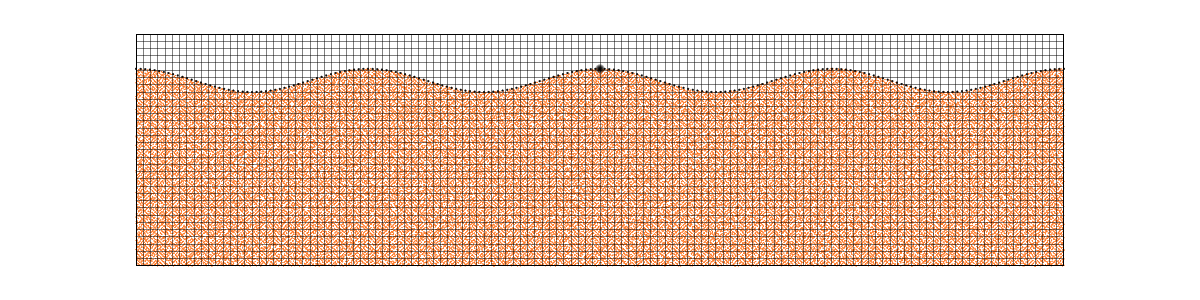

In [18]:
# plot material type and passive tracer swarms
materialFilter = materialIndex > 0
figsize=(1200,300)
figMaterial = glucifer.Figure( figsize=figsize)
figMaterial.append( glucifer.objects.Mesh(mesh,opacity=0.5))
figMaterial.append( glucifer.objects.Points(tracerSwarm2, pointSize=10, colourBar=False) )
figMaterial.append( glucifer.objects.Points(tracerSwarm, pointSize=3, colourBar=False) )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, fn_mask=materialFilter, 
                                            pointSize=2, colourBar=False, valueRange=[0,1]) )
figMaterial.append( glucifer.objects.VectorArrows(mesh, velocityField))
figMaterial.show()

In [19]:
# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = {  materialAir  : 0.0,
                materialMantle : rho,
                }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

In [20]:
# Set a viscosity for materials.
viscosityMap = {  materialAir  : 1.0e-3,
                materialMantle : eta_eff,
                }    
viscosityFn  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

In [21]:
# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*g*z_hat

In [22]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [23]:
# define the viscoelastic stress tensor
viscousStressFn       = 2. * viscosityFn * strainRate 
elasticStressFn       = eta_eff / ( mu * dt_e ) * previousStress
viscoelasticeStressFn = viscousStressFn + elasticStressFn

# map stress tensor material type
mappingDictStress = { materialAir : viscousStressFn, 
                   materialMantle : viscoelasticeStressFn }
stressFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictStress )

In [24]:
# create stokes system, solver and advectors
stokes = uw.systems.Stokes( velocityField    = velocityField, 
                            pressureField    = pressureField,
                            voronoi_swarm    = swarm, 
                            conditions       = [dirichletBC],
                            fn_viscosity     = viscosityFn, 
                            fn_bodyforce     = buoyancyFn,         
                            fn_stresshistory = elasticStressFn, # include stress history term
                          ) 
    
solver = uw.systems.Solver( stokes )
# Optional solver settings
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

# Create a system to advect the swarm
advector        = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advectorTracer  = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )
advectorTracer2 = uw.systems.SwarmAdvector( swarm=tracerSwarm2, velocityField=velocityField, order=2 )

In [25]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt() 
    if dt > ( dt_e / 3. ): # cap dt for observation time, dte
        dt = dt_e / 3.  
    if dt > t_relax/100.:  # set this to t_relax/100 for best fit 
        dt = t_relax/100.  
        
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)

    # save stress to be transported with particle
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )

    # Advect using this timestep size.
    advector.integrate(dt)
    advectorTracer.integrate(dt)
    advectorTracer2.integrate(dt)
        
    return time+dt, step+1, dt

In [26]:
# define checkpointing file
def checkpoint():
    # save swarms
    swarmHnd        = swarm.save(        outputPath+'swarm.'       + str(step).zfill(5) +'.h5')
    tracerSwarmHnd  = tracerSwarm.save(  outputPath+'tracerSwarm.' + str(step).zfill(5) +'.h5')
    tracerSwarm2Hnd = tracerSwarm2.save( outputPath+'tracerSwarm2.'+ str(step).zfill(5) +'.h5')

    # save swarm variables
    materialIndexHnd  = materialIndex.save(  outputPath +'materialIndex.'  + str(step).zfill(5) +'.h5')
    previousStressHnd = previousStress.save( outputPath +'previousStress.'  + str(step).zfill(5) +'.h5')
    
    # save mesh
    meshHnd = mesh.save(outputPath+'mesh.'+ str(step).zfill(5) +'.h5')
    
    # save mesh variable
    velocityHnd = velocityField.save(outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd = pressureField.save(outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

    # and the xdmf files
    velocityField.xdmf(  outputPath+'velocityField.' +str(step).zfill(5)+'.xdmf',velocityHnd,      "velocity",      meshHnd, "mesh", modeltime=time)
    pressureField.xdmf(  outputPath+'pressureField.' +str(step).zfill(5)+'.xdmf',pressureHnd,      "pressure",      meshHnd, "mesh", modeltime=time)
    materialIndex.xdmf(  outputPath+'materialIndex.' +str(step).zfill(5)+'.xdmf',materialIndexHnd, "materialIndex", swarmHnd,"swarm",modeltime=time)
    previousStress.xdmf( outputPath+'previousStress.'+str(step).zfill(5)+'.xdmf',previousStressHnd,"previousStress",swarmHnd,"swarm",modeltime=time)


In [27]:
# Initialise time and timestep.
time = 0.
step = 0
dt   = 0

tTracer      = []
displacement = []

In [28]:
# time stepping loop
while time < t_relax*5.0:
    # Get instantaneous Stokes solution
    solver.solve()

    tTracer.append(time)
    displacement.append(tracerSwarm2.particleCoordinates.data[0][1])
    if(uw.rank()==0):
        with open(outputPath+'/FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, displacement[step])), fmt='%.8e')
    
    if step % 20 == 0:
        print (step, time, displacement[step])
        checkpoint()
        figMaterial.save(outputPath+"figMaterial"+str(step).zfill(4))

    # We are finished with current timestep, update.
    time, step, dt = update()

0 0.0 0.05
20 2.51327412287 0.0231107841016
40 5.02654824574 0.0133804473104
60 7.53982236862 0.00952957380193
80 10.0530964915 0.00765944607401
100 12.5663706144 0.00665961851465
120 15.0796447372 0.00608992276116
140 17.5929188601 0.00567136749939
160 20.106192983 0.00528635644713
180 22.6194671058 0.00493432472787
200 25.1327412287 0.00459468940289
220 27.6460153516 0.00427956249016
240 30.1592894745 0.00398750293124
260 32.6725635973 0.00374435310931
280 35.1858377202 0.00350927087107
300 37.6991118431 0.00326926954138
320 40.2123859659 0.00302759139839
340 42.7256600888 0.00276402324672
360 45.2389342117 0.00246980892326
380 47.7522083346 0.00225173235969
400 50.2654824574 0.00202980657508
420 52.7787565803 0.0018336404599
440 55.2920307032 0.00166678031593
460 57.8053048261 0.00155741659622
480 60.3185789489 0.00148691664513
500 62.8318530718 0.00137086833457



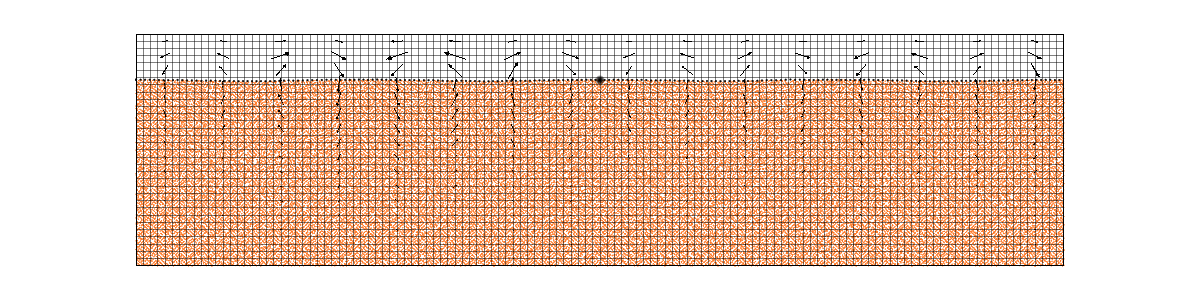

In [29]:
figMaterial.show()

Text(0.5,1,'Viscoelastic load relaxation | t_visc = dt_e = 10')

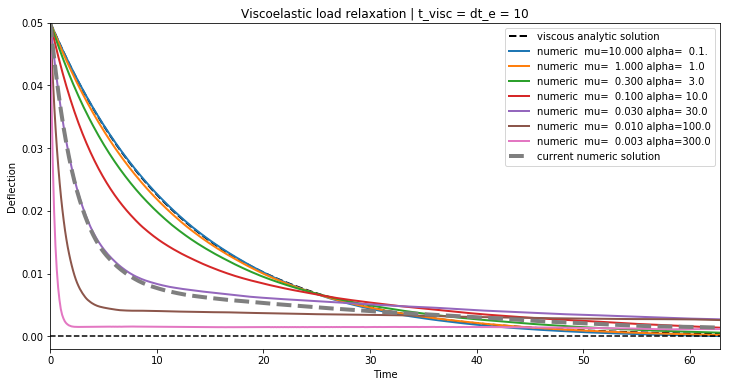

In [30]:
# load saved model run data
modelList = [
              './input/load halfspace eta=1.0 mu=10.000 alpha=  0.1.dat',
              './input/load halfspace eta=1.0 mu=  1.000 alpha=  1.0.dat',
              './input/load halfspace eta=1.0 mu=  0.300 alpha=  3.0.dat',
              './input/load halfspace eta=1.0 mu=  0.100 alpha= 10.0.dat',
              './input/load halfspace eta=1.0 mu=  0.030 alpha= 30.0.dat',
              './input/load halfspace eta=1.0 mu=  0.010 alpha=100.0.dat',
              './input/load halfspace eta=1.0 mu=  0.003 alpha=300.0.dat',
]

fig, (plot) = pyplot.subplots(1,1)
fig.set_size_inches(12, 6) 
plot.plot(t, w_t, label='viscous analytic solution', color='k', linewidth=2, linestyle='--')
for name in modelList:
    fOutput = name
    data = np.loadtxt(fOutput, unpack=True )
    step1, time1, displace = data[0], data[1], data[2]
    plot.plot(time1, displace,  label='numeric '+name[30:53], linewidth=2)

plot.plot(tTracer, displacement,  label='current numeric solution', linestyle="--", linewidth=4)   
plot.axhline(0.,color='black',linestyle='--')
plot.axis([0, t_relax*5, -0.002, w_m])
plot.set_xlabel('Time')
plot.set_ylabel('Deflection')
plot.legend(loc='best')
pyplot.title('Viscoelastic load relaxation | t_visc = dt_e = 10')
